In [1]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

In [3]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

In [16]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    # Get tweet and remove duplicates
    tweet_text = set([tweet['text'] for tweet in tweets])
    lSentiment = []
    for tweet in tweet_text:
        try:
            lTokens = tweetProcessor.process(tweet)
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
            lSentiment.append([tweet_text, sentiment])
        except KeyError as e:
            pass
    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(' '.join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

In [17]:
def save_tweets(query, max_tweets, output_file):
    api = twitterClient.twitter_client()
    tweets = []

    for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
        tweets.append(tweet._json)

    with open(output_file, 'w') as f:
        json.dump(tweets, f)

In [18]:
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 2500
output_file = 'streaming_service.json'

# save_tweets(query, max_tweets, output_file)

Don't read the json file again and again

In [19]:
with open(output_file, 'r') as f:
    for line in f:
        tweets = json.loads(line)

In [20]:
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`','’', '‘']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

## Sentiment values

In [21]:
lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)
# lSentiment = vaderSentimentAnalysis(args.tweetsFile, args.print, tweetProcessor)

In [22]:
streaming_tweets = pd.DataFrame(lSentiment)
streaming_tweets.columns = ['text','Sentiment']

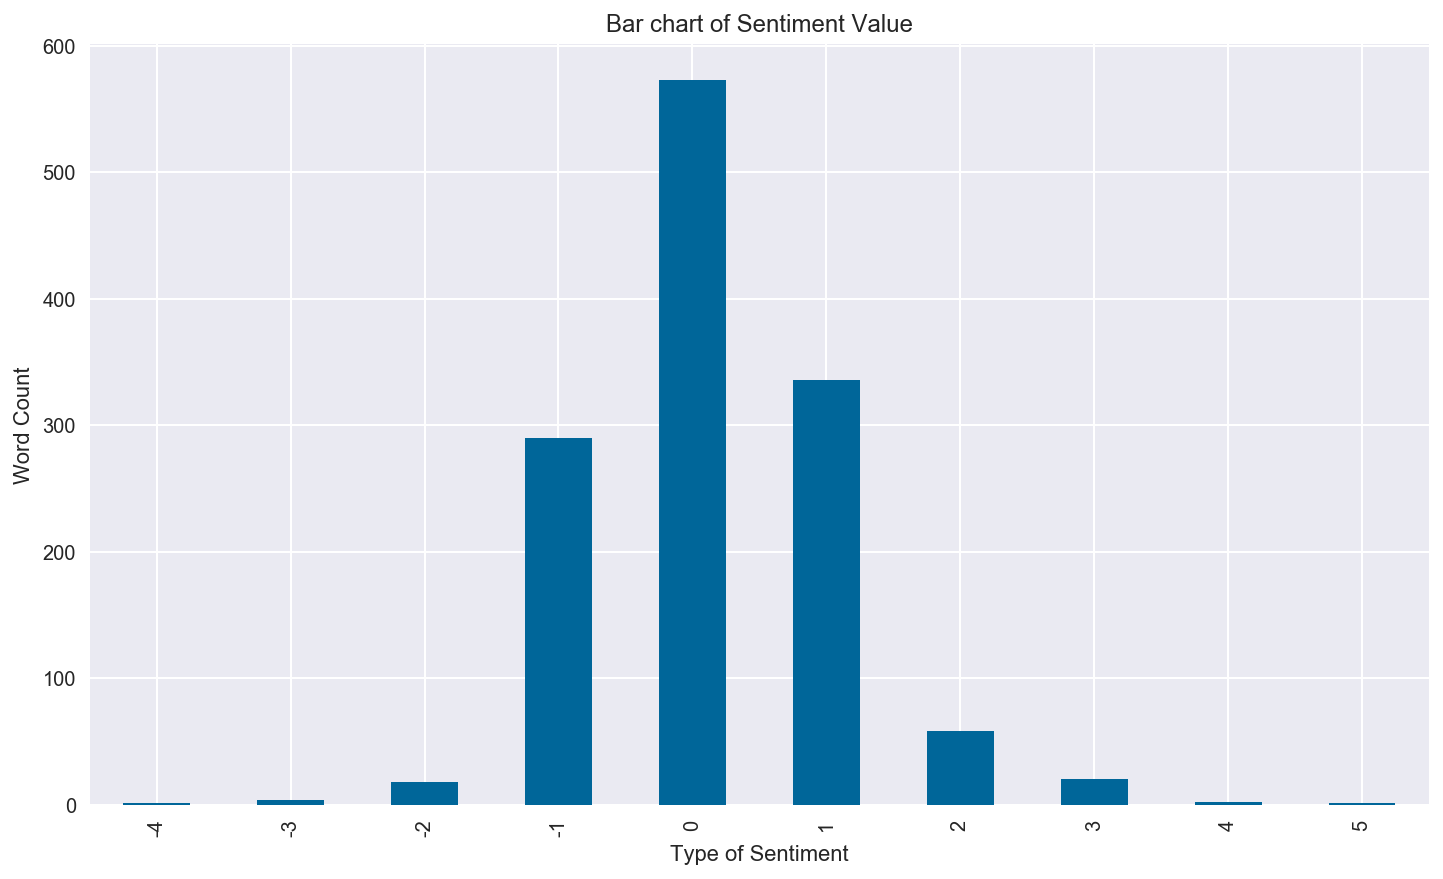

In [23]:
plt.rcParams["figure.figsize"] = (12,7)
pd.value_counts(streaming_tweets['Sentiment'].values, 
                sort=True, ascending=False).sort_index().plot(kind='bar', color='#006699')
plt.ylabel('Word Count')
plt.xlabel('Type of Sentiment')
plt.title('Bar chart of Sentiment Value')
plt.legend().set_visible(False)

* From the chart We can see most of the tweets for Media Streaming are Neutral

* Negative Tweets are Higher than the positive tweets

Next we can analyze some most positive and negative tweets

In [24]:
conditions = [
    (streaming_tweets['Sentiment'] > 0),
    (streaming_tweets['Sentiment'] < 0),
    (streaming_tweets['Sentiment'] == 0),]
choices = ['Positive', 'Negative', 'Neutral']
streaming_tweets['sentiment_type'] = np.select(conditions, choices)

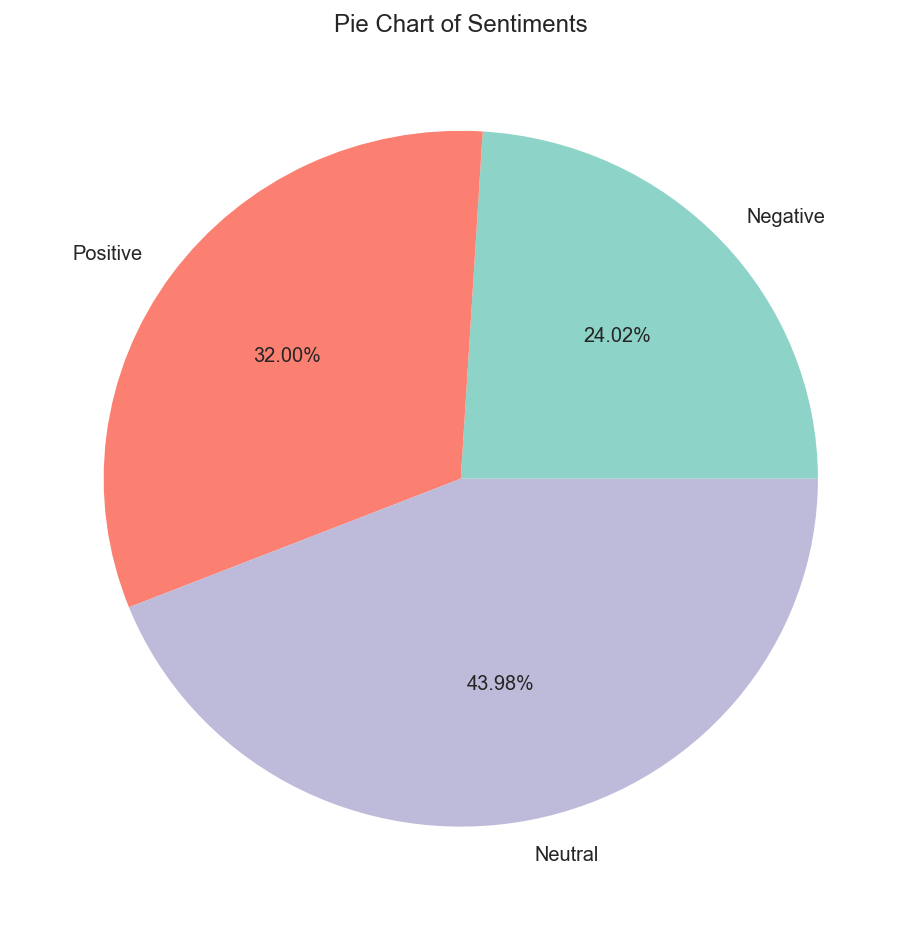

In [31]:
def make_pie_chart(data, column, title = 'Pie chart'):
    plt.rcParams["figure.figsize"] = (8,8)
    color_brewer_set2 = ["#8DD3C7","#FB8072","#BEBADA","#FFFFB3",
                         "#80B1D3","#FDB462","#B3DE69","#FCCDE5", ]

    pd.value_counts(data[column].values, sort=True, ascending=True). \
    plot(kind='pie',autopct='%1.2f%%', colors=color_brewer_set2)
    plt.title(f'Pie Chart of {title}')
    plt.xlabel('')
    plt.ylabel('')
make_pie_chart(streaming_tweets,'sentiment_type','Sentiments')

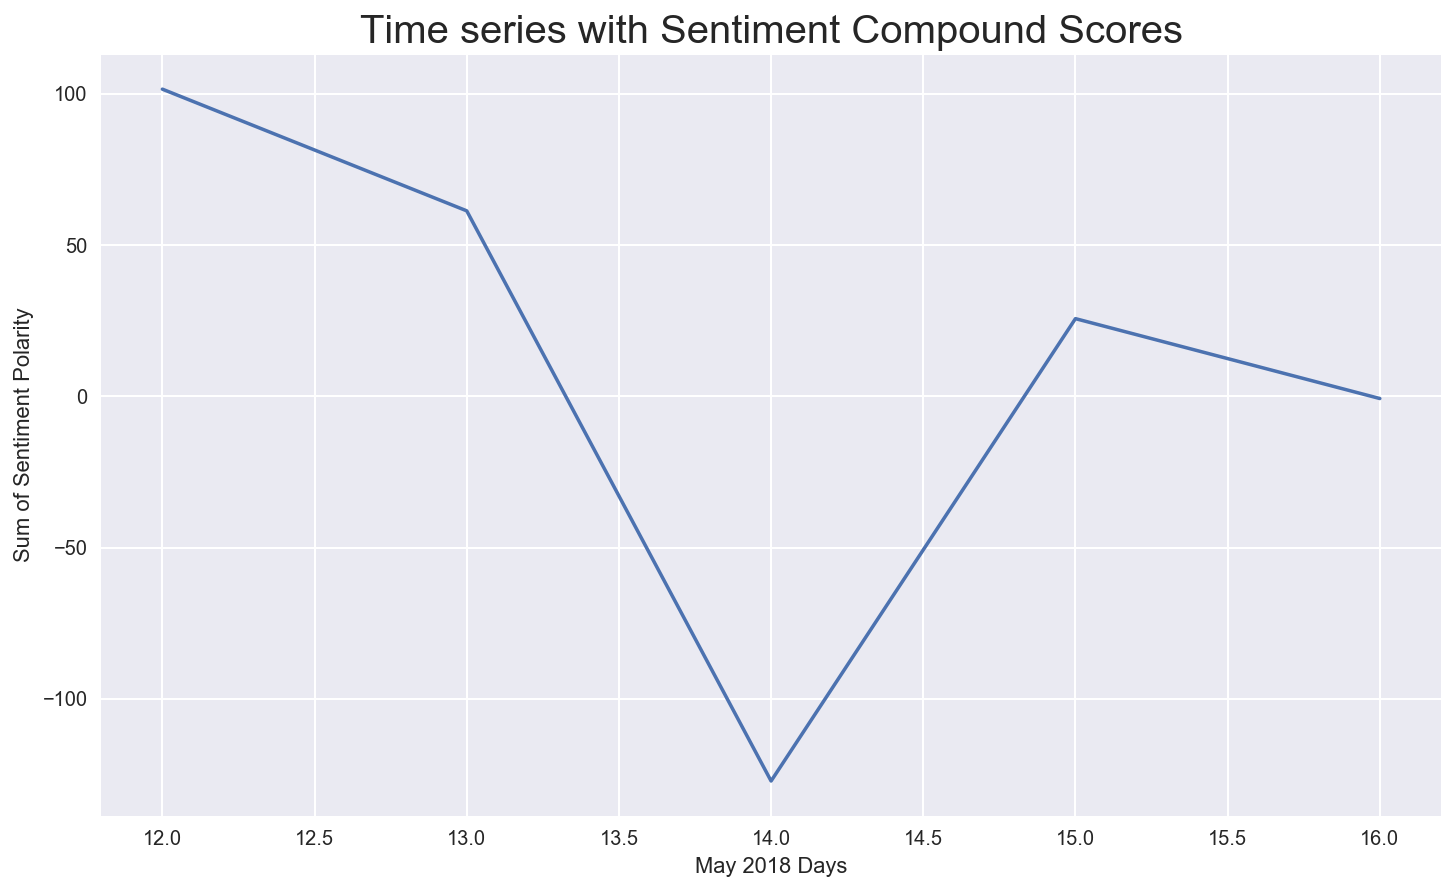

In [33]:
sentiment = vaderSentimentAnalysis(tweets, tweetProcessor)
streaming_compound = pd.DataFrame(sentiment)
streaming_compound.columns = ['Timestamp', 'text','compound']

times = pd.DatetimeIndex(streaming_compound['Timestamp'])
plt.rcParams["figure.figsize"] = (12,7)
streaming_compound.groupby(times.day).compound.sum().plot()
plt.title('Time series with Sentiment Compound Scores', fontsize=20)
plt.xlabel('May 2018 Days')
plt.ylabel('Sum of Sentiment Polarity')
plt.show()

We have many negative tweets on 14-May-2018. This need to be studied as it affected the whole data set polarity

## Key words analysis

**Most Used Keywords**

In [27]:
from collections import Counter
def get_frequent_keywords(tweets, tweetProcessor, limit=15):
    tweet_text = set([tweet['text'] for tweet in tweets])
    freq_counter = Counter()
    for tweet in tweet_text:
        tokens = tweetProcessor.process(tweet)
        freq_counter.update(tokens)
    return freq_counter.most_common(limit)

In [34]:
freq = get_frequent_keywords(tweets, tweetProcessor)
freq_df = pd.DataFrame(freq, columns=['word','count'])
freq_df.sort_values('count', ascending=False, inplace=True)

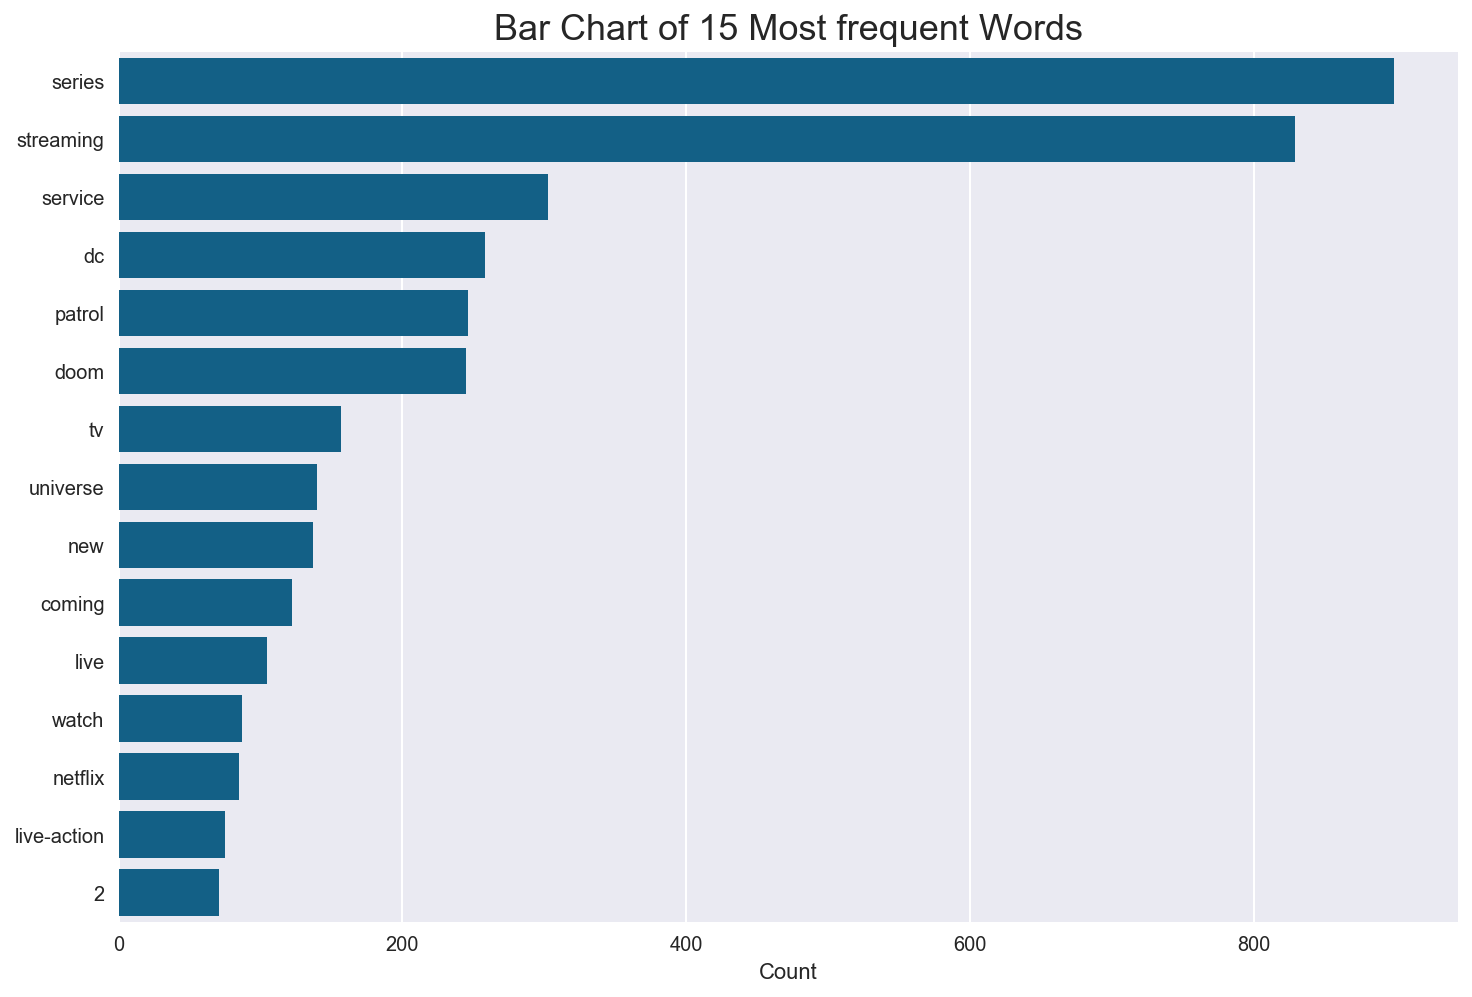

In [35]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 15 Most frequent Words', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()